# Early Prediction of Sepsis from Clinical Data: 
# the PhysioNet/Computing in Cardiology Challenge 2019
8 4 2023
K. Kh

In [1]:
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score


In [2]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
#import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [4]:
combined = pd.read_csv('Dataset.csv')
combined.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [5]:
combined.drop(columns='Unnamed: 0')

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,21,83.0,99.0,NaN,121.0,77.0,54.0,22.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,22,0,113911
1552206,22,80.0,92.0,NaN,102.0,73.0,51.0,24.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,23,0,113911
1552207,23,95.0,97.0,36.7,128.5,83.0,58.5,25.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,24,0,113911
1552208,24,104.0,99.0,NaN,127.0,85.0,59.0,24.0,NaN,NaN,...,NaN,NaN,88.00,0,1.0,0.0,-2.93,25,0,113911


In [ ]:
rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [8]:
display(df_test.shape)

(761995, 44)

In [9]:
df_train.head(15)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
5,5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,6,0,17072
6,6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,7,0,17072
7,7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,8,0,17072
8,8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,9,0,17072
9,9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,10,0,17072


In [10]:
df_train = pd.read_csv('data_part1.csv')  # 45 col
df_test = pd.read_csv('data_part2.csv')

In [11]:
df_train.head(15)
df_train.columns
patients = list(df_test['Patient_ID'].unique())
len(patients)

20000

In [12]:
null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

In [13]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())
df_train_impute.head()

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [14]:
one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)

#df_train_impute = df_train_impute.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])

df_train_impute.head()

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

df_train_impute.head()

# standard normalization

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()


Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                  
1          132940     0  0.705950 -0.685827 -1.105823 -0.157228  0.043895   
           132941     1  0.705950 -0.685827 -1.105823 -0.157228  0.043895   
           132942     2  0.236955  0.555029 -1.105823  0.547988  0.600192   
           132943     3  0.295579 -0.685827 -1.105823  0.868472  2.083649   
           132944     4  1.057696 -2.702217 -1.105823  0.868472  1.063772   

                        BUN  Chloride  Creatinine   Glucose       Hct  \
Patient_ID                                                              
1          132940 -0.413042 -3.697098   -0.560343  1.444179  1.231844   
           132941 -0.413042 -3.697098   -0.560343  1.444179  1.231844   
           132942 -0.413042 -3.697098   -0.560343  1.444179  1.231844   
           132943 -0.413042 -3.697098   -0.560343  1.444179  1.231844   
           132944 -0.413042 -3.697098   -0.560343  1.444179  1.231844   

                        Hgb       WBC  Platelets    Age  HospAdmTime  ICULOS  \
Patient_ID                                                                     
1          132940  1.114903 -1.288936   1.062522  83.14        -0.03       1   
           132941  1.114903 -1.288936   1.062522  83.14        -0.03       2   
           132942  1.114903 -1.288936   1.062522  83.14        -0.03       3   
           132943  1.114903 -1.288936   1.062522  83.14        -0.03       4   
           132944  1.114903 -1.288936   1.062522  83.14        -0.03       5   

                   SepsisLabel     0      1  
Patient_ID                                   
1          132940            0  True  False  
           132941            0  True  False  
           132942            0  True  False  
           132943            0  True  False  
           132944            0  True  False

In [15]:
df_train_impute = df_train_impute.dropna()
null_values = df_train_impute.isnull().mean()*100
null_values

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))
majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

number of sepsis label 1 is 15284
while number of sepsis label 0 is 750935


In [37]:
df_train_impute['SepsisLabel'].value_counts()

SepsisLabel
0    30568
1    15284
Name: count, dtype: int64

In [38]:
df_train_impute.columns


Index([       'Hour',          'HR',       'O2Sat',        'Temp',
               'MAP',        'Resp',         'BUN',    'Chloride',
        'Creatinine',     'Glucose',         'Hct',         'Hgb',
               'WBC',   'Platelets',         'Age', 'HospAdmTime',
            'ICULOS', 'SepsisLabel',             0,             1],
      dtype='object')

In [16]:
def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  return df


In [17]:
def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [18]:
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
df_train_impute.head()


,,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
6354,687822,10,-0.232040,-1.306254,1.431622,-1.826535,-1.068698,0.507409,-0.591863,3.066707,-0.154232,-0.619702,-1.182771,1.382366,1.117021,68.64,-67.72,12,0,True,False
6601,434604,11,-1.404527,-0.065399,-0.058623,-0.859918,-1.254130,0.821651,-0.591863,-0.135134,0.667694,0.717526,0.525756,1.228768,1.440941,58.58,-69.36,12,0,False,True
8460,199433,6,2.288808,-0.375613,1.659858,-0.422070,0.229328,-1.606523,-0.409202,-1.262219,0.536857,-0.455120,-0.357965,0.697284,0.974601,41.05,-134.35,7,0,True,False
4488,383183,44,-0.876908,-0.685827,-1.105823,0.196005,-0.234253,0.256318,0.869424,0.341885,-1.067730,-0.125956,0.172268,1.116277,-2.098846,77.58,-0.03,45,0,False,True
624,274398,9,0.530077,0.865243,-0.729905,-1.731137,-0.326969,1.592849,2.696033,0.341885,-0.563579,-0.948865,-1.123856,0.010919,1.326346,88.28,-607.30,10,0,False,True


In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36681, 19)
(36681,)
(9171, 19)
(9171,)


In [33]:
# ANN
model = Sequential()

# layers
model.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = 19))
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # categorical_crossentropy binary_crossentropy

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 64, epochs = 200, validation_split=0.25)

Epoch 1/200


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7243 - loss: 0.5929 - val_accuracy: 0.7392 - val_loss: 0.5397
Epoch 2/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7545 - loss: 0.5339 - val_accuracy: 0.7465 - val_loss: 0.5323
Epoch 3/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7593 - loss: 0.5257 - val_accuracy: 0.7468 - val_loss: 0.5304
Epoch 4/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7636 - loss: 0.5157 - val_accuracy: 0.7511 - val_loss: 0.5222
Epoch 5/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7674 - loss: 0.5099 - val_accuracy: 0.7553 - val_loss: 0.5199
Epoch 6/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7668 - loss: 0.5043 - val_accuracy: 0.7541 - val_loss: 0.5151
Epoch 7/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7713 - loss: 0.4957 - val_accuracy: 0.7576 - val_loss: 0.5065
Epoch 8/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7722 - loss: 0.4921 - val_accuracy: 0.7564

430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8993 - loss: 0.2360 - val_accuracy: 0.8564 - val_loss: 0.3679
Epoch 102/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8982 - loss: 0.2331 - val_accuracy: 0.8640 - val_loss: 0.3839
Epoch 103/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8990 - loss: 0.2302 - val_accuracy: 0.8541 - val_loss: 0.3956
Epoch 104/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9001 - loss: 0.2392 - val_accuracy: 0.8626 - val_loss: 0.3734
Epoch 105/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9000 - loss: 0.2311 - val_accuracy: 0.8601 - val_loss: 0.3821
Epoch 106/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9005 - loss: 0.2335 - val_accuracy: 0.8592 - val_loss: 0.3721
Epoch 107/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8947 - loss: 0.2393 - val_accuracy: 0.8577 - val_loss: 0.3847
Epoch 108/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8999 - loss: 0.2302 - val_ac

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9223 - loss: 0.1825 - val_accuracy: 0.8766 - val_loss: 0.3891
Epoch 200/200
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9248 - loss: 0.1776 - val_accuracy: 0.8705 - val_loss: 0.3844



val_accuracy is: 84.24%


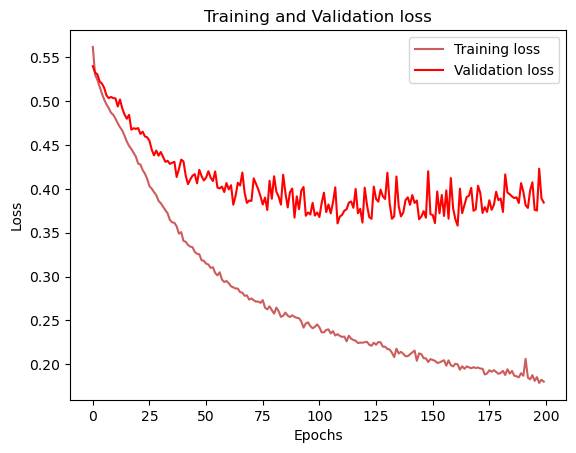

In [34]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))

history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

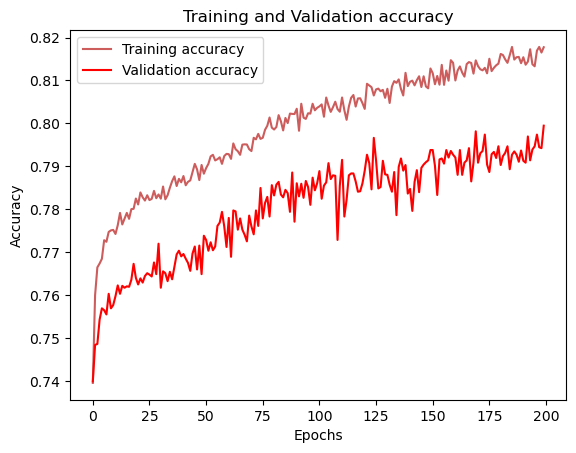

In [30]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


<Axes: >

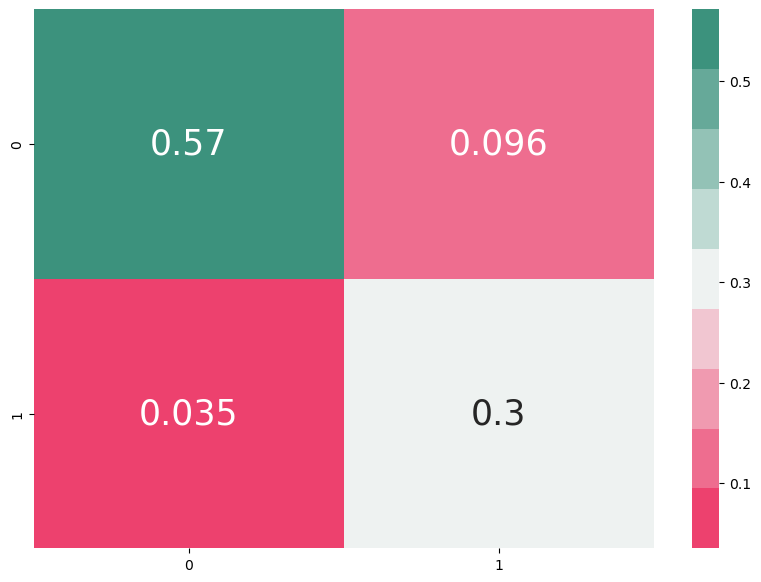

In [35]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.4)
np.set_printoptions()

# Getting the confusion matrix
cmap1 = sns.diverging_palette(2, 165, s=80, l=55, n=9)
plt.subplots(figsize=(10,7))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':25})

In [36]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.86      0.90      6121
           1       0.76      0.89      0.82      3050

    accuracy                           0.87      9171
   macro avg       0.85      0.88      0.86      9171
weighted avg       0.88      0.87      0.87      9171



In [27]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
hist=model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

evaluate_model(y_test,rcf_predictions)



TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

Accuracy: 0.8807245616159985
Precision: 0.1032183908045977
Recall: 0.45839714139867277
F1 Score: 0.16849610657660194
AUC-ROC: 0.6752786281991981
Mean Absolute Error: 0.11927543838400151
Root Mean Squared Error: 0.34536276345894834


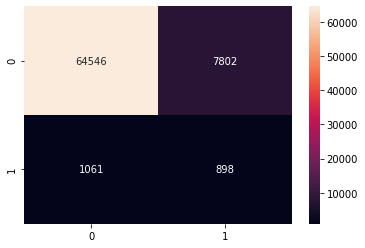

In [29]:
df = get_data_ready(df_test)
X = df.drop('SepsisLabel', axis=1)
y = df['SepsisLabel']
rcf_predictions = model.predict(X)
evaluate_model(y,rcf_predictions)


In [30]:
print(classification_report(y, rcf_predictions))


              precision    recall  f1-score   support

           0       0.98      0.89      0.94     72348
           1       0.10      0.46      0.17      1959

    accuracy                           0.88     74307
   macro avg       0.54      0.68      0.55     74307
weighted avg       0.96      0.88      0.92     74307

